In [382]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold
import statistics as st

In [238]:
fogData = xr.open_dataset('../../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
yAll=yAll/25.0

In [239]:
#Surface data
t2mData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')
z500Data = xr.open_dataset('../../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')

In [240]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [241]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [242]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [243]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [244]:
# AO data
AOData = xr.open_dataset('../../../../Data/AO_EU/AO_Calculated.nc')
aoTS=AOData.AO
Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(aoTS.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), aoTS[t].values)
AOData=xr.Dataset({'AO': (('time','latitude','longitude'), Darray)},
                  coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude}) 
# EU data
EUData = xr.open_dataset('../../../../Data/AO_EU/EU.nc')
EUData.EUVal
euTS=EUData.EUVal
Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(euTS.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), euTS[t].values)
EUData=xr.Dataset({'EU': (('time','latitude','longitude'), Darray)},
                  coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [245]:
# create mask
oro = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100))
oro.values = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100)).values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

In [246]:
# 5Day and 30Day Mean
#AO
AO5D=AOData.AO.rolling(time=5).mean()

AO5DAll=AO5D[((AO5D.time.dt.month>11) | (AO5D.time.dt.month<2)) & 
             (AO5D.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),
                                           longitude=slice(50,100))

#EU
EU5D=EUData.EU.rolling(time=5).mean()

EU5DAll=EU5D[((EU5D.time.dt.month>11) | (EU5D.time.dt.month<2)) & 
             (EU5D.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),
                                           longitude=slice(50,100))

t1=AO5DAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
AO5DAll.values=t1.unstack()

t1=EU5DAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
EU5DAll.values=t1.unstack()

AO5DAll.values=AO5DAll.values*mask
AO5DAll.values=xr.where(np.isnan(AO5DAll.values),  0.000000000001,AO5DAll.values)

EU5DAll.values=EU5DAll.values*mask
EU5DAll.values=xr.where(np.isnan(EU5DAll.values),  0.000000000001,EU5DAll.values)

In [247]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)


In [248]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [249]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()


t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()

In [250]:
t2mTsAll.values=t2mTsAll.values*mask
wsTsAll.values=wsTsAll.values*mask
rhTsAll.values=rhTsAll.values*mask
invTsAll.values=invTsAll.values*mask
ushearTsAll.values=ushearTsAll.values*mask
wTsAll.values=wTsAll.values*mask


In [251]:
t2mTsAll.values=xr.where(np.isnan(t2mTsAll.values),  0.000000000001,t2mTsAll.values)
wsTsAll.values=xr.where(np.isnan(wsTsAll.values),  0.000000000001,wsTsAll.values)
rhTsAll.values=xr.where(np.isnan(rhTsAll.values),  0.000000000001,rhTsAll.values)
invTsAll.values=xr.where(np.isnan(invTsAll.values),  0.000000000001,invTsAll.values)
ushearTsAll.values=xr.where(np.isnan(ushearTsAll.values),  0.000000000001,ushearTsAll.values)
wTsAll.values=xr.where(np.isnan(wTsAll.values),  0.000000000001,wTsAll.values)


In [252]:
t2m_train,t2m_test,ws_train,ws_test,rh_train,rh_test,inv_train,inv_test, w_train, w_test,ushear_train, ushear_test,ao_train,ao_test,eu_train,eu_test,y_train,y_test= train_test_split( t2mTsAll,wsTsAll,rhTsAll,invTsAll, wTsAll,ushearTsAll,AO5DAll,EU5DAll,yAll,test_size=0.20, random_state=0)

In [253]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape


wstrain=ws_train.values
wstrain=wstrain[:,:,:,None]
wstrain.shape

rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape


invtrain=inv_train.values
invtrain=invtrain[:,:,:,None]
invtrain.shape

wtrain=w_train.values
wtrain=wtrain[:,:,:,None]
wtrain.shape

usheartrain=ushear_train.values
usheartrain=usheartrain[:,:,:,None]
usheartrain.shape

aotrain=ao_train.values
aotrain=aotrain[:,:,:,None]
aotrain.shape

eutrain=eu_train.values
eutrain=eutrain[:,:,:,None]
eutrain.shape


(1934, 18, 26, 1)

In [254]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape


wstest=ws_test.values
wstest=wstest[:,:,:,None]
wstest.shape

rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape


invtest=inv_test.values
invtest=invtest[:,:,:,None]
invtest.shape

wtest=w_test.values
wtest=wtest[:,:,:,None]
wtest.shape

usheartest=ushear_test.values
usheartest=usheartest[:,:,:,None]
usheartest.shape

aotest=ao_test.values
aotest=aotest[:,:,:,None]
aotest.shape

eutest=eu_test.values
eutest=eutest[:,:,:,None]
eutest.shape


(484, 18, 26, 1)

In [255]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(484, 1)

In [256]:
#X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
#X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest,aotest,eutest,ssttest])
X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest,aotest,eutest])
X_test.shape

#X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
#X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain,ssttrain])
X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain,aotrain,eutrain])
X_train.shape

(8, 1934, 18, 26, 1)

In [257]:
X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

(484, 8, 18, 26, 1)

Epoch 1/20
61/61 [==============================] - 2s 22ms/step - loss: 0.1990 - mse: 0.0637
Epoch 2/20
61/61 [==============================] - 1s 21ms/step - loss: 0.1638 - mse: 0.0412
Epoch 3/20
61/61 [==============================] - 1s 20ms/step - loss: 0.1430 - mse: 0.0324
Epoch 4/20
61/61 [==============================] - 1s 20ms/step - loss: 0.1241 - mse: 0.0253
Epoch 5/20
61/61 [==============================] - 1s 20ms/step - loss: 0.1205 - mse: 0.0251
Epoch 6/20
61/61 [==============================] - 1s 20ms/step - loss: 0.1081 - mse: 0.0197
Epoch 7/20
61/61 [==============================] - 1s 20ms/step - loss: 0.1039 - mse: 0.0182
Epoch 8/20
61/61 [==============================] - 1s 20ms/step - loss: 0.0990 - mse: 0.0162
Epoch 9/20
61/61 [==============================] - 1s 20ms/step - loss: 0.0970 - mse: 0.0163
Epoch 10/20
61/61 [==============================] - 1s 20ms/step - loss: 0.0919 - mse: 0.0150
Epoch 11/20
61/61 [==============================] - 1s 20m

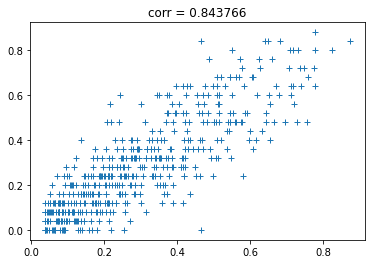

In [316]:
    from numpy.random import seed
    seed(123)
    from tensorflow import random
    random.set_seed(123)
    model = Sequential()
    model.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
    model.add(AveragePooling3D(pool_size=2,padding='same'))
    model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    model.add(AveragePooling3D(pool_size=2,padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    model.add(AveragePooling3D(pool_size=2,padding='same'))
    model.add(Dropout(0.2))


    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.01)
    model.compile(optimizer='adam', loss='mae',  metrics='mse')
    history = model.fit(X_train_reshape, y_train, epochs=20)
    yy_test = model.predict(X_test_reshape)
    
    test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y_test,'+')
    


In [317]:
t2mAll=t2mTsAll.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape


wsAll=wsTsAll.values
wsAll=wsAll[:,:,:,None]
wsAll.shape

rhAll=rhTsAll.values
rhAll=rhAll[:,:,:,None]
rhAll.shape


invAll=invTsAll.values
invAll=invAll[:,:,:,None]
invAll.shape

wAll=wTsAll.values
wAll=wAll[:,:,:,None]
wAll.shape

ushearAll=ushearTsAll.values
ushearAll=ushearAll[:,:,:,None]
ushearAll.shape

aoAll=AO5DAll.values
aoAll=aoAll[:,:,:,None]
aoAll.shape

euAll=EU5DAll.values
euAll=euAll[:,:,:,None]
euAll.shape


(2418, 18, 26, 1)

In [318]:
#X_All=np.array([t2mAll,rhAll,wsAll,invAll,wAll,ushearAll,aoAll,euAll,sstAll])
X_All=np.array([t2mAll,rhAll,wsAll,invAll,wAll,ushearAll,aoAll,euAll])
X_All.shape

X_All_reshape = np.einsum('lkija->klija',X_All)
X_All_reshape.shape

(2418, 8, 18, 26, 1)

In [319]:
yLR=model.predict(X_All_reshape)

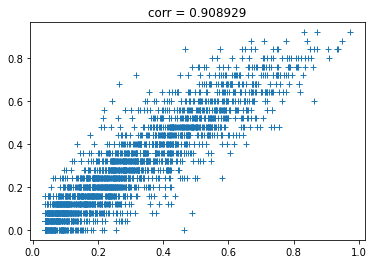

In [320]:
    test_corr = np.corrcoef(yLR[:,0],yAll)[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yLR,yAll,'+')

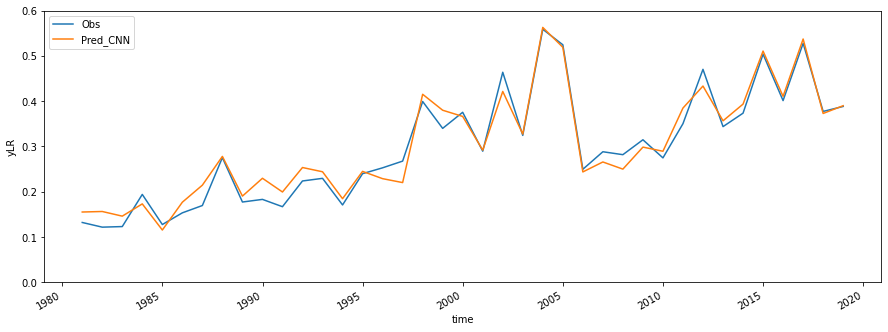

In [321]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR[:,0])}, coords={'time': yAll.time})
dump(y_predLin_ds.yLR,'TSdataCNN.joblib')
plt.figure(figsize=[15,5])
yAll.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_CNN')
#dump(y,'TS1dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()

In [349]:
### no fog 0 (<=0.02) , medium fog 1-11 (>0.02 && <=0.46) , widespread fog >11 (>0.46)

ynf=yAll[yAll<0.040].shape[0]
print(ynf)

yintf=yAll[(yAll<=0.46) & (yAll>=0.04)].shape[0]
print(yintf)

yWd=yAll[yAll>0.46].shape[0]
print(yWd)




yLRnf=y_predLin_ds.yLR[y_predLin_ds.yLR<0.040].shape[0]
print(yLRnf)

yLRintf=y_predLin_ds.yLR[(y_predLin_ds.yLR<=0.46) & (y_predLin_ds.yLR>=0.040)].shape[0]
print(yLRintf)

yLRWd=y_predLin_ds.yLR[y_predLin_ds.yLR>0.46].shape[0]
print(yLRWd)


print((ynf+yintf+yWd))
print((yLRnf+yLRintf+yLRWd))


125
1705
588
80
1792
546
2418
2418


<xarray.DataArray 'fogdata' (time: 0)>
array([], dtype=float64)
Coordinates:
  * time     (time) datetime64[ns]

In [353]:
y_predLin_ds.yLR.time
yAll.time

<xarray.DataArray 'time' (time: 2418)>
array(['1980-01-01T00:00:00.000000000', '1980-01-02T00:00:00.000000000',
       '1980-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31

In [374]:
### no fog 0 (<=0.02) , medium fog 1-11 (>0.02 && <=0.46) , widespread fog >11 (>0.46)
nf=list()
nfP=list()

medf=list()
medfP=list()

wdf=list()
wdfP=list()

for yr in range(1980,2019,1):
    #print(yr)
    dStart=datetime.datetime(yr-1, 12, 1)
    #print(dStart)
    dEnd=datetime.datetime(yr, 1, 31)
    #print(dEnd)
    yAct=yAll.sel(time=slice(dStart,dEnd))
    yPred=y_predLin_ds.yLR.sel(time=slice(dStart,dEnd))
    nf.append(yAct[yAct<0.040].shape[0])
    nfP.append(yPred[yPred<0.040].shape[0])
    
    
    medf.append(yAct[(yAct<=0.46) & (yAct>=0.04)].shape[0])
    medfP.append(yPred[(yPred<=0.46) & (yPred>=0.04)].shape[0])
    
    wdf.append(yAct[yAct>0.46].shape[0])
    wdfP.append(yPred[yPred>0.46].shape[0])
    
print(sum(nf))
print(sum(medf))
print(sum(wdf))

print(sum(nfP))
print(sum(medfP))
print(sum(wdfP))
    
    
print(sum(nf)+sum(medf)+sum(wdf))  
print(sum(nfP)+sum(medfP)+sum(wdfP))




125
1674
588
79
1762
546
2387
2387


3.2051282051282053
2.0256410256410255
3.8263593193825436
3.0735474060472816


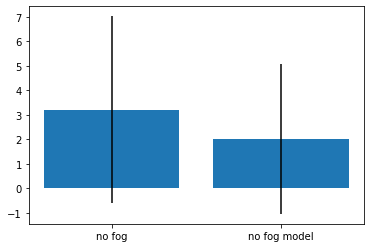

<ErrorbarContainer object of 3 artists>

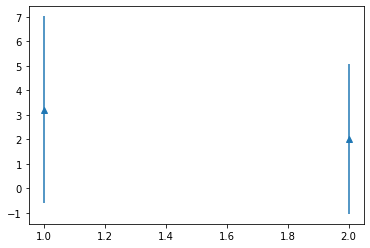

In [392]:
print(sum(nf)/len(nf))
print(sum(nfP)/len(nfP))
mnf=sum(nf)/len(nf)
mnfP=sum(nfP)/len(nfP)

print(st.stdev(nf))
print(st.stdev(nfP))
snf=st.stdev(nf)
snfP=st.stdev(nfP)

# build a bar plot
plt.bar(['no fog', 'no fog model'],[mnf, mnfP],yerr=[snf, snfP])
#plt.xlabel('3D-printer Fillament Material')
#plt.ylabel('Tensile Strength (MPa)')
#plt.title('Tensile Strength of 3-D Printed ABS and HIPS Tensile Bars')
plt.show()

x=[1,2]
plt.errorbar(x, [mnf, mnfP], [snf, snfP], linestyle='None', marker='^')

42.92307692307692
45.17948717948718
10.722295059176108
12.609252648816003


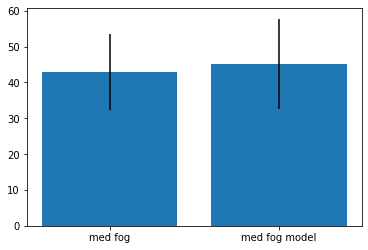

In [388]:
print(sum(medf)/len(medf))
print(sum(medfP)/len(medfP))

print(st.stdev(medf))
print(st.stdev(medfP))

mmednf=sum(medf)/len(medf)
mmedfP=sum(medfP)/len(medfP)

smedf=st.stdev(medf)
smedfP=st.stdev(medfP)

# build a bar plot
plt.bar(['med fog', 'med fog model'],[mmednf, mmedfP],yerr=[smedf, smedfP])
#plt.xlabel('3D-printer Fillament Material')
#plt.ylabel('Tensile Strength (MPa)')
#plt.title('Tensile Strength of 3-D Printed ABS and HIPS Tensile Bars')
plt.show()

In [386]:
print(sum(wdf)/len(wdf))
print(sum(wdfP)/len(wdfP))

print(st.stdev(wdf))
print(st.stdev(wdfP))

15.076923076923077
14.0
12.329648937215518
13.751554936002501


15.076923076923077
14.0
12.329648937215518
13.751554936002501


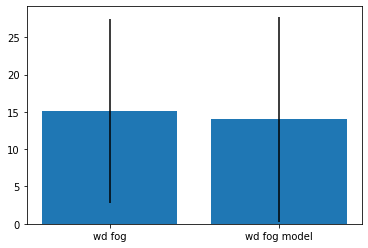

In [389]:
print(sum(wdf)/len(wdf))
print(sum(wdfP)/len(wdfP))

print(st.stdev(wdf))
print(st.stdev(wdfP))

mwdnf=sum(wdf)/len(wdf)
mwdfP=sum(wdfP)/len(wdfP)

swdf=st.stdev(wdf)
swdfP=st.stdev(wdfP)

# build a bar plot
plt.bar(['wd fog', 'wd fog model'],[mwdnf, mwdfP],yerr=[swdf, swdfP])
#plt.xlabel('3D-printer Fillament Material')
#plt.ylabel('Tensile Strength (MPa)')
#plt.title('Tensile Strength of 3-D Printed ABS and HIPS Tensile Bars')
plt.show()

In [391]:
wdfP

[0,
 0,
 0,
 2,
 0,
 1,
 3,
 1,
 8,
 0,
 12,
 0,
 2,
 0,
 2,
 5,
 6,
 14,
 31,
 31,
 10,
 21,
 27,
 33,
 42,
 10,
 0,
 9,
 1,
 23,
 27,
 13,
 22,
 31,
 30,
 37,
 21,
 38,
 33]

{'whiskers': [<matplotlib.lines.Line2D at 0x2b404c7f5040>,
 'caps': [<matplotlib.lines.Line2D at 0x2b404c7f5d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b404c7efe80>,
 'medians': [<matplotlib.lines.Line2D at 0x2b404c7039d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b404c7030a0>,
 'means': []}

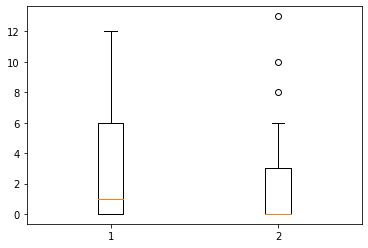

In [373]:
data=[nf,nfP]
plt.boxplot(data)
#plt.boxplot(nf)

{'whiskers': [<matplotlib.lines.Line2D at 0x2b40e1b4e820>,
 'caps': [<matplotlib.lines.Line2D at 0x2b40e1b4e370>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b40e1b4e730>,
 'medians': [<matplotlib.lines.Line2D at 0x2b40e1b48340>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b40e1b48880>,
 'means': []}

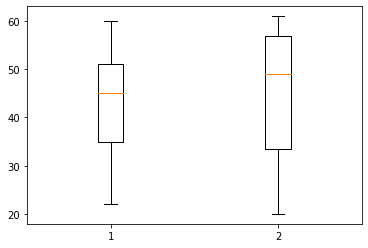

In [375]:
data=[medf,medfP]
plt.boxplot(data)
#plt.boxplot(nf)

{'whiskers': [<matplotlib.lines.Line2D at 0x2b40e1ad5d90>,
 'caps': [<matplotlib.lines.Line2D at 0x2b40cffa8f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b40e1ad5370>,
 'medians': [<matplotlib.lines.Line2D at 0x2b40cffa8c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b40e0c93190>,
 'means': []}

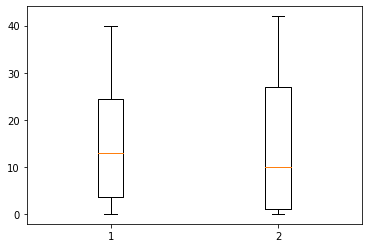

In [376]:
data=[wdf,wdfP]
plt.boxplot(data)

Text(0.5, 1.0, 'CNN')

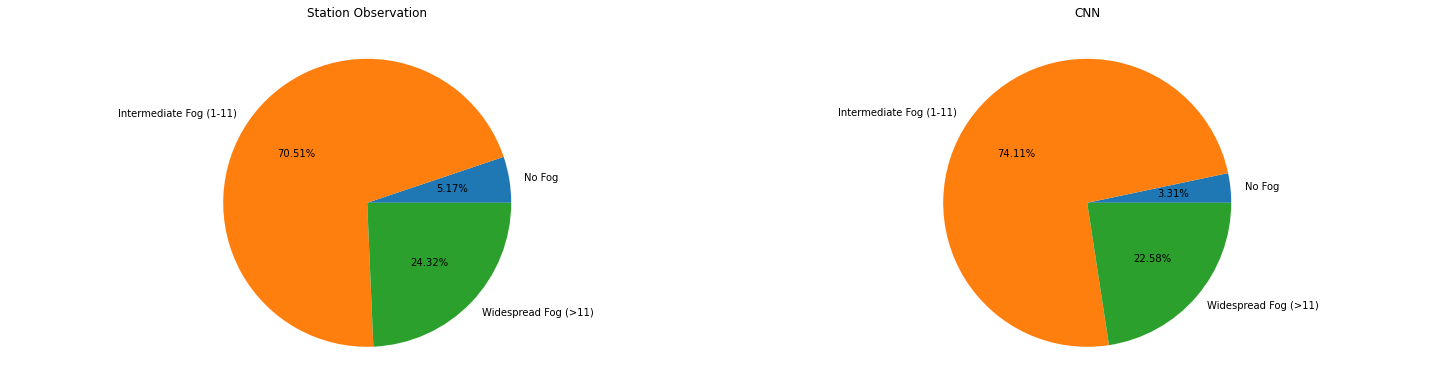

In [350]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf,yintf,yWd]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')
ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf,yLRintf,yLRWd]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')

In [ ]:
pie1dataObs = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
pie1dataLR = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
#dump(pie1dataObs, 'pie1dataObs_1.joblib') 
dump(pie1dataLR,'piedataCNN.joblib')

In [ ]:
# save model and architecture to single file
model.save("modelCNN.h5")
print("Saved model to disk")